In [39]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.patches import Ellipse

#Set up matplotlib and numpy for Jupyter Notebook
%matplotlib inline

In [40]:
with fits.open("image.fits") as hdul:
    data = hdul[0].data

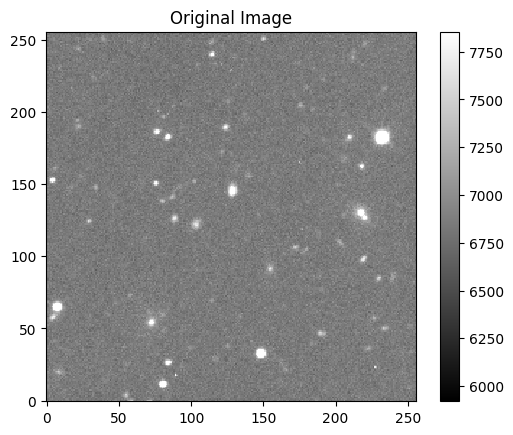

In [41]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.title("Original Image")
plt.savefig('original_image.png')  # Save the figure
plt.show()

In [42]:
bkg = sep.Background(data)
# Prepare background subtracted image
data_sub = data - bkg

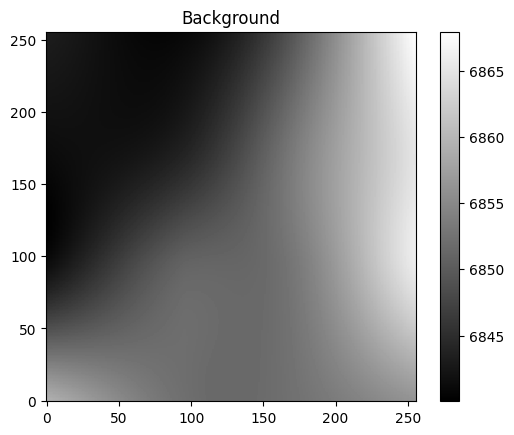

In [43]:
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background")
plt.savefig('background_image.png')  # Save the figure
plt.show()

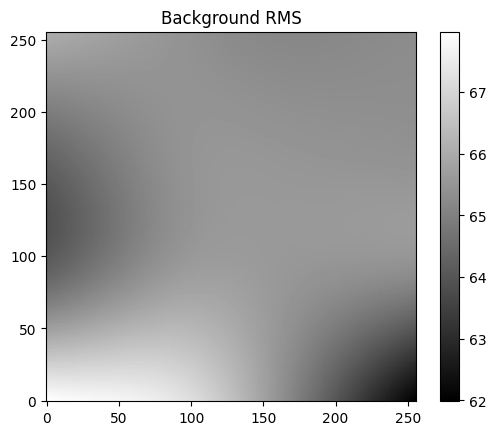

In [44]:
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.title("Background RMS")
plt.savefig('background_noise.png')  # Save the figure
plt.show()


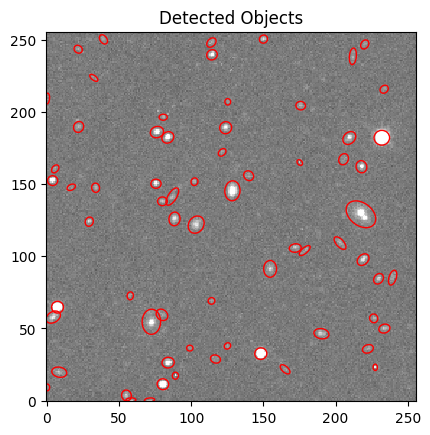

In [45]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.title("Detected Objects")
plt.savefig('detected_objects.png')  # Save the figure
plt.show()

In [46]:
# Perform circular aperture photometry
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)


In [47]:
# Print flux information for the first few objects
for i in range(10):
    print(f"object {i}: flux = {flux[i]:.2f}, fluxerr = {fluxerr[i]:.2f}, flag = {flag[i]}")

object 0: flux = 2249.16, fluxerr = 291.03, flag = 16
object 1: flux = 3092.22, fluxerr = 291.59, flag = 16
object 2: flux = 5949.87, fluxerr = 356.56, flag = 0
object 3: flux = 1851.43, fluxerr = 295.03, flag = 16
object 4: flux = 72736.39, fluxerr = 440.17, flag = 0
object 5: flux = 3860.76, fluxerr = 352.16, flag = 0
object 6: flux = 6418.91, fluxerr = 357.46, flag = 0
object 7: flux = 2210.71, fluxerr = 350.79, flag = 0
object 8: flux = 2741.61, fluxerr = 352.28, flag = 0
object 9: flux = 20916.88, fluxerr = 376.97, flag = 0


In [48]:
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data_udf = hdul[0].data
    data_udf = data_udf.byteswap().newbyteorder()


In [49]:
bkg_udf = sep.Background(data_udf)
data_sub_udf = data_udf - bkg_udf


In [50]:
objects_udf = sep.extract(data_sub_udf, 1.5, err=bkg_udf.globalrms)
print(f"Number of sources detected: {len(objects_udf)}")


Number of sources detected: 8640


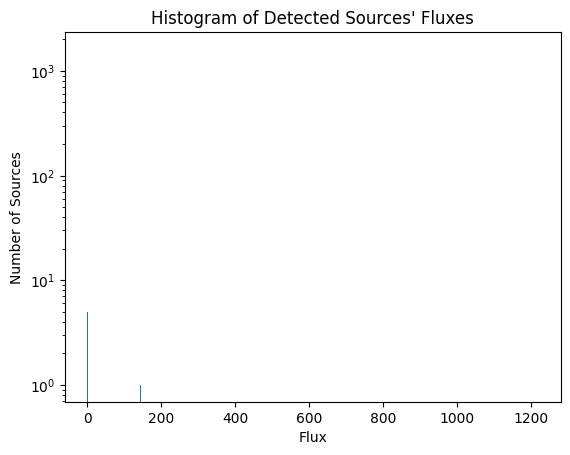

In [51]:
# Extract the fluxes
fluxes = [obj['flux'] for obj in objects_udf]

# Plot the histogram
plt.hist(fluxes, bins='auto', log=True)
plt.title("Histogram of Detected Sources' Fluxes")
plt.xlabel("Flux")
plt.ylabel("Number of Sources")
plt.savefig('flux_histogram.png')
plt.show()


In [52]:
mean_flux = np.mean(fluxes)
median_flux = np.median(fluxes)
std_flux = np.std(fluxes)
largest_outlier_flux = np.max(fluxes)
largest_outlier_index = np.argmax(fluxes)
largest_outlier_position = (objects_udf[largest_outlier_index]['x'], objects_udf[largest_outlier_index]['y'])
outlier_std_devs_from_mean = (largest_outlier_flux - mean_flux) / std_flux


In [53]:
print(f"Mean flux: {mean_flux}")
print(f"Median flux: {median_flux}")
print(f"Standard deviation of fluxes: {std_flux}")
print(f"Largest outlier flux: {largest_outlier_flux}, at position {largest_outlier_position}")
print(f"The largest outlier is {outlier_std_devs_from_mean} standard deviations from the mean")


Mean flux: 1.1726778032743217
Median flux: 0.034888697788119316
Standard deviation of fluxes: 17.547420912246842
Largest outlier flux: 1218.3980712890625, at position (1914.2549094883857, 1134.3164850742164)
The largest outlier is 69.36776632720151 standard deviations from the mean


In [54]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline


In [55]:
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    f160w_data = hdul[0].data.byteswap().newbyteorder()
f160w_norm = f160w_data / np.max(f160w_data)

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdul:
    f125w_data = hdul[0].data.byteswap().newbyteorder()
f125w_norm = f125w_data / np.max(f125w_data)

with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    f105w_data = hdul[0].data.byteswap().newbyteorder()
f105w_norm = f105w_data / np.max(f105w_data)


In [56]:
def asinh_stretch(img, a=0.1):
    return np.arcsinh(img * a) / np.arcsinh(a)

f160w_stretched = asinh_stretch(f160w_norm)
f125w_stretched = asinh_stretch(f125w_norm)
f105w_stretched = asinh_stretch(f105w_norm)



In [57]:
rgb_stretched = np.stack([f160w_stretched, f125w_stretched, f105w_stretched], axis=-1)

# Normalize the combined image
rgb_stretched -= np.min(rgb_stretched)
rgb_stretched /= np.max(rgb_stretched)


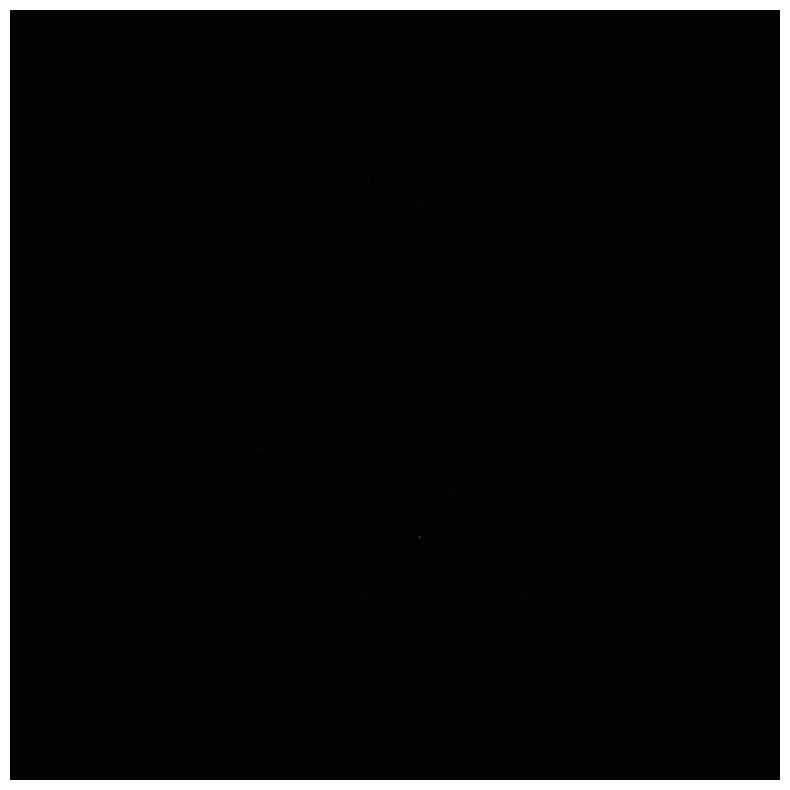

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb_stretched, origin='lower')
plt.axis('off')
plt.savefig('hudf_rgb_stretched_normalized.png', bbox_inches='tight', pad_inches=0)
plt.show()
